In [3]:
import imageio as iio
import math

from skimage import filters
from skimage.color import rgb2gray  # only needed for incorrectly saved images
from skimage.measure import regionprops
from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert
from skimage import feature
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour


from scipy import ndimage
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import ezdxf

/var/folders/t8/4l7cl3f50bxf2hs1wf7rbgjm0000gp/T/ipykernel_10717/1764833684.py:11: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  cent_pt = ndimage.measurements.center_of_mass(im_bin)


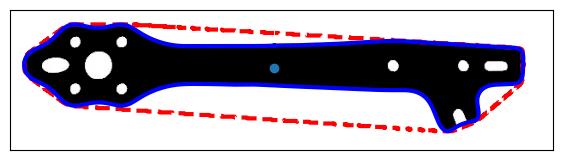

In [28]:
demo_img = Image.open("old_stuff/demo1.jpg")

def polyimg_to_dxf_spline(img, msp, s_foreground_thresh=160, alpha=0.05, beta=15, gamma=0.035, gaussian_sigma=3, preview=False):
    im_gray = np.array(img.convert('L'))
    im_bool = im_gray < s_foreground_thresh
    im_bin255 = im_bool * 255
    im_bin = im_bool * 1.
    im_gray_thresh = im_gray.copy()
    im_gray_thresh[im_gray_thresh < s_foreground_thresh] = 0
    
    cent_pt = ndimage.measurements.center_of_mass(im_bin)
    convimg = convex_hull_image(im_bin)
    edges = feature.canny(convimg, sigma=gaussian_sigma)
    
    indices = np.where(edges == [1])
    coordinates = [list(a) for a in zip(indices[0], indices[1])]
    coordinates.sort(key=lambda p: math.atan2(p[1]-cent_pt[1],p[0]-cent_pt[0]))
    
    init = np.array([[x[0] for x in coordinates], [x[1] for x in coordinates]]).T
    
    snake = active_contour(
        gaussian(im_gray_thresh, sigma=gaussian_sigma, preserve_range=False),
        init,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
    )
    
    if preview:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.imshow(im_gray_thresh, cmap=plt.cm.gray)
        ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
        ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
        ax.scatter([cent_pt[1]], [cent_pt[0]])
        ax.set_xticks([]), ax.set_yticks([])
        ax.axis([0, im_gray_thresh.shape[1], im_gray_thresh.shape[0], 0])
        
        plt.show()
    
    fit_points = [(*ptt, 0) for ptt in snake] + [(*snake[0], 0)]
    spline = msp.add_spline(fit_points)
    
    return spline
    
doc = ezdxf.new("R2000")

msp = doc.modelspace()

polyimg_to_dxf_spline(demo_img, msp, preview=True)

doc.saveas("outR.dxf")